# Google Colab notebook with implementation of Age Progression/Regression by Conditional Adversarial Autoencoder by Zhifei Zhang, Yang Song, Hairong Qi

In [1]:
#Mounting the drive

import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Bash commands to unpack our dataset and move python scripts to one directory. One should use them only after applying upload.py script from the project's repository.

In [0]:
!mkdir data && tar xvzf "/content/drive/My Drive/UTKFace.tar.gz" &> /dev/null && mv UTKFace/ data/
!cp -a "/content/drive/My Drive/aging/" .

Imports + setting parameters for neural networks training. Parameters are based on suggestions from the original paper.

In [3]:
%matplotlib inline
import shutil
from typing import List
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from IPython import display
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from aging.dataloader import ImageTargetFolder
from aging.nets import Encoder, Generator, Dimg, Dz
from aging.utils import convert_age, index_to_one_hot, total_variation_loss, rename_files
from aging.parameters import n_l, n_z, image_size, batch_size

# Setting environmental variable to resolve error:
# OMP: Error #15: Initializing libiomp5.dylib, but found libomp.dylib already initialized.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Dataset

DESTINATION_DIR = 'data'
ngpu = 1
num_epochs = 10
num_classes = 10
lr = 2e-4
betas = (0.5, 0.999)
SEED = 42
torch.manual_seed(SEED)

Function to rename our files in order to easily retrieve age and gender afterwards.

In [0]:
rename_files()

Loading data with custom dataset class (to enable additional target extraction).

In [0]:
dataset = ImageTargetFolder(root=DESTINATION_DIR,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ]))
# Regex to extract age and gender from 
regex = '^.*?([0-9].*?)_([0-9])_.*$'
labels = [re.findall(regex, x[0])[0] for x in dataset.imgs]
labels = list(map(lambda x: (int(x[0]), int(x[1])), labels))
dataset.targets = labels

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Showing some examples from the dataset.

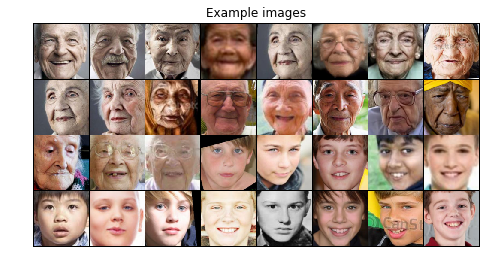

In [6]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title("Example images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, 
                                         normalize=True).cpu(), (1, 2, 0)))
plt.show()

Weights, optimizers and losses initialization.

In [0]:

# weight initialization called on all neural networks.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Initialize neural networks with possible GPU support.
netE = Encoder().to(device)
netG = Generator().to(device)
netDz = Dz().to(device)
netDimg = Dimg().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netE.apply(weights_init)
netG.apply(weights_init)
netDz.apply(weights_init)
netDimg.apply(weights_init)

# Definition of optimizers
optimizerE = torch.optim.Adam(netE.parameters(), betas=betas, lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), betas=betas, lr=lr)
optimizerDz = torch.optim.Adam(netDz.parameters(), betas=betas, lr=lr)
optimizerDimg = torch.optim.Adam(netDimg.parameters(), betas=betas, lr=lr)

# Definition of losses
BCEloss = nn.BCELoss()
L1loss = nn.L1Loss()
L2loss = nn.MSELoss()
CEloss = nn.CrossEntropyLoss()

The following stepes are presented in training our CAAE:

1 - Autoencoder with L1 loss - we are going to use it instead of L2 loss which can be found in original paper due to sparser representation - by using this penalty we will achieve fewer nodes that should learn latent representation, omitting reduntant information in the process. It trains both netE and netG. \\
2 - Discriminator on images generated by G. It's a part of the architecture which is similar to the one found in original GAN - Dimg learns to distinguish between fake and real images in order to optimize training of the generator. \\
3 - This step to required to smoothen distribution of codes generated from the image by encoder. As written in the original paper "The discriminator on z, denoted by Dz, imposes a prior
distribution (e.g., uniform distribution) on z. Specifically,
Dz aims to discriminate the z generated by encoder E. Simultaneously, E will be trained to generate z that could fool
Dz. Such adversarial process forces the distribution of the
generated z to gradually approach the prior.". The rest of this procedure is going to be handled in Step 6. \\
4 - Total variation loss on images reconstructed by the generator. It allows to denoise images based on the principle that signals with excessive and possibly spurious detail have high total variation, that is, the integral of the absolute gradient of the signal is high. In the result, we may end up with images having less details, however the most important features of them (like egdes) are going to remain, with much less noise present. The idea is taken from the article [1].  \\
5 - Combining previous losses to obtain full Encoder-Generator loss. \\
6 - Training Dz on prior distribution (being uniform distribution from (-1, 1) interval). It completes the procedure cited from the article in Step 3. \\
7 - Completes distriminator training by comparing labels generated by prior distribution (z_prior) with real ones and these generated by Encoder (z) with fake ones.

[1] https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.117.1675&rep=rep1&type=pdf

In [0]:
def plot_loss(fig, ax, key, data):
    sns.lineplot(x = 'epoch', y = key, data = data, ax = ax)
    ax.set_title(key)
    fig.canvas.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [0]:
# Variable to progress/regress age

fixed_l = -torch.ones(80 * 10).view(80, 10).to(device)
for index, value in enumerate(fixed_l):
    value[index // 8] = 1

fixed_l_v = Variable(fixed_l)

# Output directory

output_directory = './results'
output_losses = './losses'

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
if not os.path.exists(output_losses):
    os.mkdir(output_losses)
# Number of epochs

epochs = 50
EG_L1_loss_full, D_img_loss_full, Ez_loss_full, G_tv_loss_full, EG_loss_full = [], [], [], [], []
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (10, 10))
axes = axes.flatten()
for epoch in range(epochs):
    for index, data in enumerate(dataloader):
        # Extracting data and converting labels to one hot encoded format
        image, (label, gender) = data
        label = Variable(label).view(-1, 1)
        gender = Variable(gender.float())
        # Convert age to intervals
        label = torch.tensor([convert_age(age) for age in label])
        # Convert age to one-hot
        label = index_to_one_hot(label, num_classes)
        image = Variable(image.to(device))
        label = label.to(device)
        gender = gender.to(device)
        batch_size = image.size(0)
        if epoch == 0 and index == 0:
            fixed_noise = image[:8].repeat(10, 1, 1, 1)
            fixed_g = gender[:8].view(-1, 1).repeat(10, 1)

            fixed_img_v = Variable(fixed_noise)
            fixed_g_v = Variable(fixed_g)

        # prior distribution z_prior, real_label, fake_label
        z_prior = Variable(torch.FloatTensor(batch_size * n_z).uniform_(-1, 1). \
                          to(device)).view(batch_size, n_z)
        real_label = Variable(torch.ones(batch_size).fill_(1).to(device)).view(-1, 1)
        fake_label = Variable(torch.ones(batch_size).fill_(0).to(device)).view(-1, 1)

        ## train Encoder and Generator with reconstruction loss
        netE.zero_grad()
        netG.zero_grad()
    
        # Step 1 - L1 reconstruction loss
        z = netE(image)
        reconst = netG(z, label, gender)
        EG_L1_loss = L1loss(reconst, image)

        # Step 2 - GAN loss
        # Training of disciminator on images - comparing reconstru
        D_reconst, _ = netDimg(reconst, label.view(batch_size, n_l, 1, 1), 
                               gender.view(batch_size, 1, 1, 1))
        D_img_loss = BCEloss(D_reconst, real_label)

        ## Step 3 - Ez loss
        Dz_prior = netDz(z_prior)
        Dz = netDz(z)
        Ez_loss = BCEloss(Dz, real_label)

        ## Step 4 - Total variation loss
        reconst = netG(z.detach(), label, gender)
        G_tv_loss = total_variation_loss(reconst)

        ## Step 5 - Combining losses to get full Encoder-Generator loss
        EG_loss = EG_L1_loss + 0.0005 * D_img_loss + 0.05 * Ez_loss + G_tv_loss
        EG_loss.backward()

        optimizerE.step()
        optimizerG.step()

        ## Step 6 - train netDz with prior distribution U(-1,1)
        netDz.zero_grad()
        Dz_prior = netDz(z_prior)
        Dz = netDz(z.detach())

        Dz_loss = BCEloss(Dz_prior, real_label) + BCEloss(Dz, fake_label)
        Dz_loss.backward()
        optimizerDz.step()

        ## Step 7 - train D_img with real images
        netDimg.zero_grad()
        D_img, D_clf = netDimg(image, label.view(batch_size, n_l, 1, 1), 
                               gender.view(batch_size, 1, 1, 1))
        D_reconst, _ = netDimg(reconst.detach(), label.view(batch_size, n_l, 1, 1), 
                               gender.view(batch_size, 1, 1, 1))

        D_loss = BCEloss(D_img, real_label) + BCEloss(D_reconst, fake_label)
        D_loss.backward()
        optimizerDimg.step()

    EG_L1_loss_full.append(EG_L1_loss.item())
    D_img_loss_full.append(D_img_loss.item())
    Ez_loss_full.append(Ez_loss.item())
    G_tv_loss_full.append(G_tv_loss.item())
    EG_loss_full.append(EG_loss.item())

    losses = pd.DataFrame({
        'EG_L1_loss_full': EG_L1_loss_full,
        'D_img_loss_full': D_img_loss_full,
        'Ez_loss_full': Ez_loss_full,
        'G_tv_loss_full': G_tv_loss_full,
        'EG_loss_full': EG_loss_full,
        'epoch': list(range(epoch + 1))
        })
    for index, key in enumerate(losses.keys()):
        ax = axes[epoch]
        plot_loss(fig, ax, key, losses)
    np.save(os.path.join(output_losses, f"EG_L1_loss_full_{epoch}.npy"), EG_L1_loss_full)
    np.save(os.path.join(output_losses, f"D_img_loss_full_{epoch}.npy"), D_img_loss_full)
    np.save(os.path.join(output_losses, f"Ez_loss_full_{epoch}.npy"), Ez_loss_full)
    np.save(os.path.join(output_losses, f"G_tv_loss_full_{epoch}.npy"), G_tv_loss_full)
    np.save(os.path.join(output_losses, f"EG_loss_full_{epoch}.npy"), EG_loss_full)
    os.system('rm -rf "/content/drive/My Drive/losses" && mkdir "/content/drive/My Drive/losses"')
    os.system(f'mv -v /content/losses/* "/content/drive/My Drive/losses"')

    if epoch%10==0:
        print("The current losses are: ", f"EG_L1_loss: {EG_L1_loss}", f"D_img_loss: {D_img_loss}",
              f"Ez_loss: {Ez_loss}", f"G_tv_loss: {G_tv_loss}", f"EG_loss: {EG_loss}", sep='\n')
        torch.save(netE.state_dict(), os.path.join(output_directory, f"netE_{epoch}.pickle"))
        torch.save(netG.state_dict(), os.path.join(output_directory, f"netG_{epoch}.pickle"))
        torch.save(netDz.state_dict(), os.path.join(output_directory, f"netDz_{epoch}.pickle"))
        torch.save(netDimg.state_dict(), os.path.join(output_directory, f"netDimg_{epoch}.pickle"))
        np.save(os.path.join(output_directory, f"EG_L1_loss_full_{epoch}.npy"), EG_L1_loss_full)
        os.system('rm -rf "/content/drive/My Drive/results" && mkdir "/content/drive/My Drive/results"')
        os.system(f'mv -v /content/results/* "/content/drive/My Drive/results"')

